In [24]:
# reference : https://wikidocs.net/80787

In [1]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin-1')

In [3]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [4]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
data['v2'].nunique(), data['v1'].nunique()

(5169, 2)

In [7]:
data.drop_duplicates(subset=['v2'], inplace=True) # v2 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


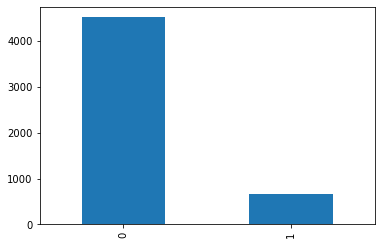

In [8]:
data['v1'].value_counts().plot(kind='bar');

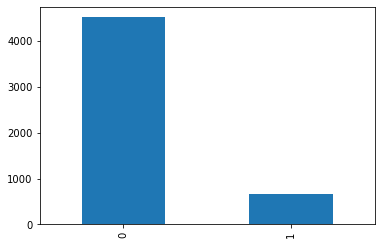

In [9]:
data['v1'].value_counts().plot(kind='bar');

In [10]:
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


In [11]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [12]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_data) # 5169개의 행을 가진 X의 각 행에 토큰화를 수행
sequences = tokenizer.texts_to_sequences(X_data) # 단어를 숫자값, 인덱스로 변환하여 저장

In [13]:
print(sequences[:5])

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137], [49, 306, 435, 6], [53, 537, 8, 20, 4, 934, 2, 220, 706, 267, 70, 2, 2, 359, 537, 604, 82, 436, 185, 707, 437], [6, 226, 152, 23, 347, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 198, 105, 438]]


In [14]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 4135
테스트 데이터의 개수: 1034


메일의 최대 길이 : 172
메일의 평균 길이 : 12.566841


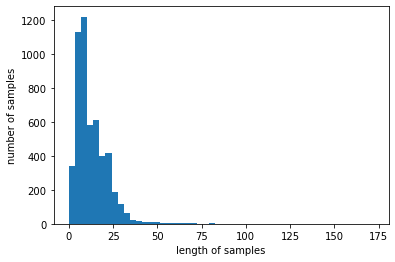

In [15]:
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
# 전체 데이터셋의 길이는 max_len으로 맞춥니다.
max_len = 172
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (5169, 172)


In [17]:
X_test = data[n_of_train:] #X_data 데이터 중에서 뒤의 1034개의 데이터만 저장
y_test = np.array(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1034개의 데이터만 저장
X_train = data[:n_of_train] #X_data 데이터 중에서 앞의 4135개의 데이터만 저장
y_train = np.array(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4135개의 데이터만 저장
print("훈련용 이메일 데이터의 크기(shape): ", X_train.shape)
print("테스트용 이메일 데이터의 크기(shape): ", X_test.shape)
print("훈련용 레이블의 크기(shape): ", y_train.shape)
print("테스트용 레이블의 크기(shape): ", y_test.shape)

훈련용 이메일 데이터의 크기(shape):  (4135, 172)
테스트용 이메일 데이터의 크기(shape):  (1034, 172)
훈련용 레이블의 크기(shape):  (4135,)
테스트용 레이블의 크기(shape):  (1034,)


In [18]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [20]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [22]:
%%time
history = model.fit(X_train, y_train, epochs = 10, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
50/52 [===========================>..] - ETA: 0s - loss: 0.0446 - acc: 0.9887
Epoch 00001: val_acc did not improve from 0.98549
52/52 [==============================] - 2s 31ms/step - loss: 0.0442 - acc: 0.9888 - val_loss: 0.0483 - val_acc: 0.9831
Epoch 2/10
49/52 [===========================>..] - ETA: 0s - loss: 0.0292 - acc: 0.9920
Epoch 00002: val_acc did not improve from 0.98549
52/52 [==============================] - 2s 30ms/step - loss: 0.0329 - acc: 0.9912 - val_loss: 0.0440 - val_acc: 0.9843
Epoch 3/10
49/52 [===========================>..] - ETA: 0s - loss: 0.0220 - acc: 0.9946
Epoch 00003: val_acc did not improve from 0.98549
52/52 [==============================] - 2s 34ms/step - loss: 0.0215 - acc: 0.9946 - val_loss: 0.0444 - val_acc: 0.9843
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 0.0179 - acc: 0.9964
Epoch 00004: val_acc did not improve from 0.98549
52/52 [==============================] - 2s 39ms/step - loss: 0.0179 - acc: 0.9964 -

In [23]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 2ms/step - loss: 0.0580 - acc: 0.9787

 테스트 정확도: 0.9787
